Data source: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

There are totally 5216 images of chest xray in gray scale and in jpeg format for training purpose. Of which , 3875 are pnuemonia cases and 1341 are normal cases.  
There are 624 images of chest xray for model testing and 16 x ray images for validation.  
This analysis focuses on performing image classification with balanced train data set.  

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split

import skimage
from skimage.io import imread
from skimage.transform import resize

In [3]:
import tensorflow as tf

In [4]:
import pickle

In [5]:
def load_image_files(container_path, dimension=(150, 150)):
    """
    Load image files with categories as subfolder names 
    which performs like scikit-learn sample dataset
    
    Parameters
    ----------
    container_path : string or unicode
        Path to the main folder holding one subfolder per category
    dimension : tuple
        size to which image are adjusted to
        
    Returns
    -------
    Bunch
    """
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    images = []
    flat_data = []
    target = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            img = skimage.io.imread(file, as_gray = True) ## need to add in plugin for reading png images.
            img_resized = resize(img, dimension, anti_aliasing=True, mode='reflect')
            #flat_data.append(img_resized.flatten()) 
            flat_data.append(img_resized) 
            images.append(img_resized)
            target.append(i)
    flat_data = np.array(flat_data)
    target = np.array(target)
    images = np.array(images)

    return Bunch(data=flat_data,
                 target=target,
                 target_names=categories,
                 images=images,
                 DESCR=descr)

In [7]:
train_dataset = load_image_files("train")

In [8]:
val_dataset = load_image_files("val")

In [9]:
test_dataset = load_image_files("test")

In [10]:
train_dataset

{'data': array([[[0.80410458, 0.80392157, 0.79215686, ..., 0.7724244 ,
          0.78054536, 0.81963399],
         [0.8       , 0.79608941, 0.79228758, ..., 0.76875817,
          0.78839216, 0.82298405],
         [0.79908497, 0.79908497, 0.79215686, ..., 0.78745098,
          0.80700654, 0.83532026],
         ...,
         [0.0579085 , 0.04321569, 0.03150327, ..., 0.18431373,
          0.19124183, 0.19607843],
         [0.05098039, 0.04313725, 0.03529412, ..., 0.17647059,
          0.18377569, 0.19160784],
         [0.05098039, 0.04313725, 0.03529412, ..., 0.16862745,
          0.17647059, 0.18020915]],
 
        [[0.00226353, 0.03595451, 0.07309804, ..., 0.21921569,
          0.19540549, 0.18721569],
         [0.01176471, 0.0492549 , 0.08273725, ..., 0.22313725,
          0.20813647, 0.2       ],
         [0.0214902 , 0.05716863, 0.08968627, ..., 0.22705882,
          0.2149098 , 0.20366275],
         ...,
         [0.        , 0.03921569, 0.16588235, ..., 0.        ,
          0.    

In [11]:
pd.Series(train_dataset['target']).value_counts()

0    3875
1    1341
dtype: int64

In [12]:
pd.Series(val_dataset['target']).value_counts()

1    8
0    8
dtype: int64

In [13]:
pd.Series(test_dataset['target']).value_counts()

0    390
1    234
dtype: int64

Pneumonia cases are more than Normal cases.  

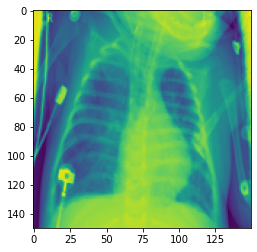

In [14]:
plt.figure()
plt.imshow(train_dataset['images'][0])
#plt.colorbar()
plt.grid(False)
plt.show()

In [49]:
class_names = ['PNEUMONIA', 'NORMAL']
train_images = train_dataset['images']
train_labels = train_dataset['target']

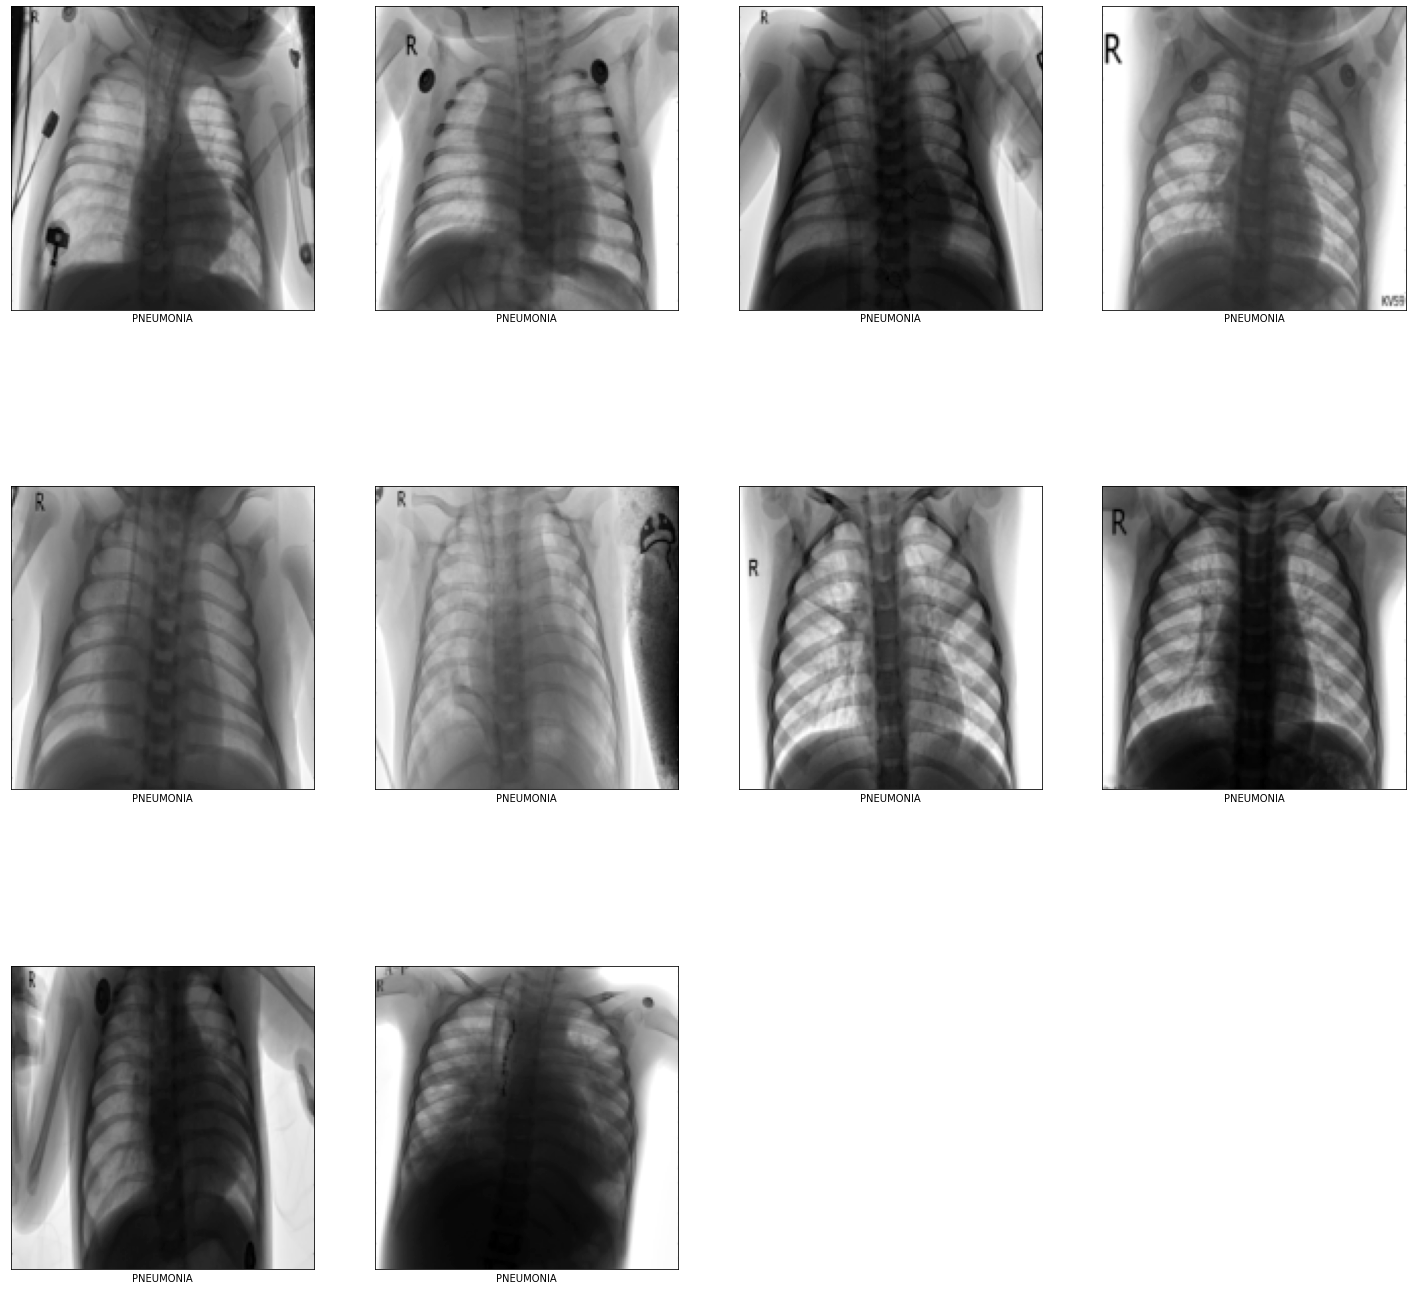

In [39]:
plt.figure(figsize=(25,25))
for i in range(10):
    plt.subplot(3,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

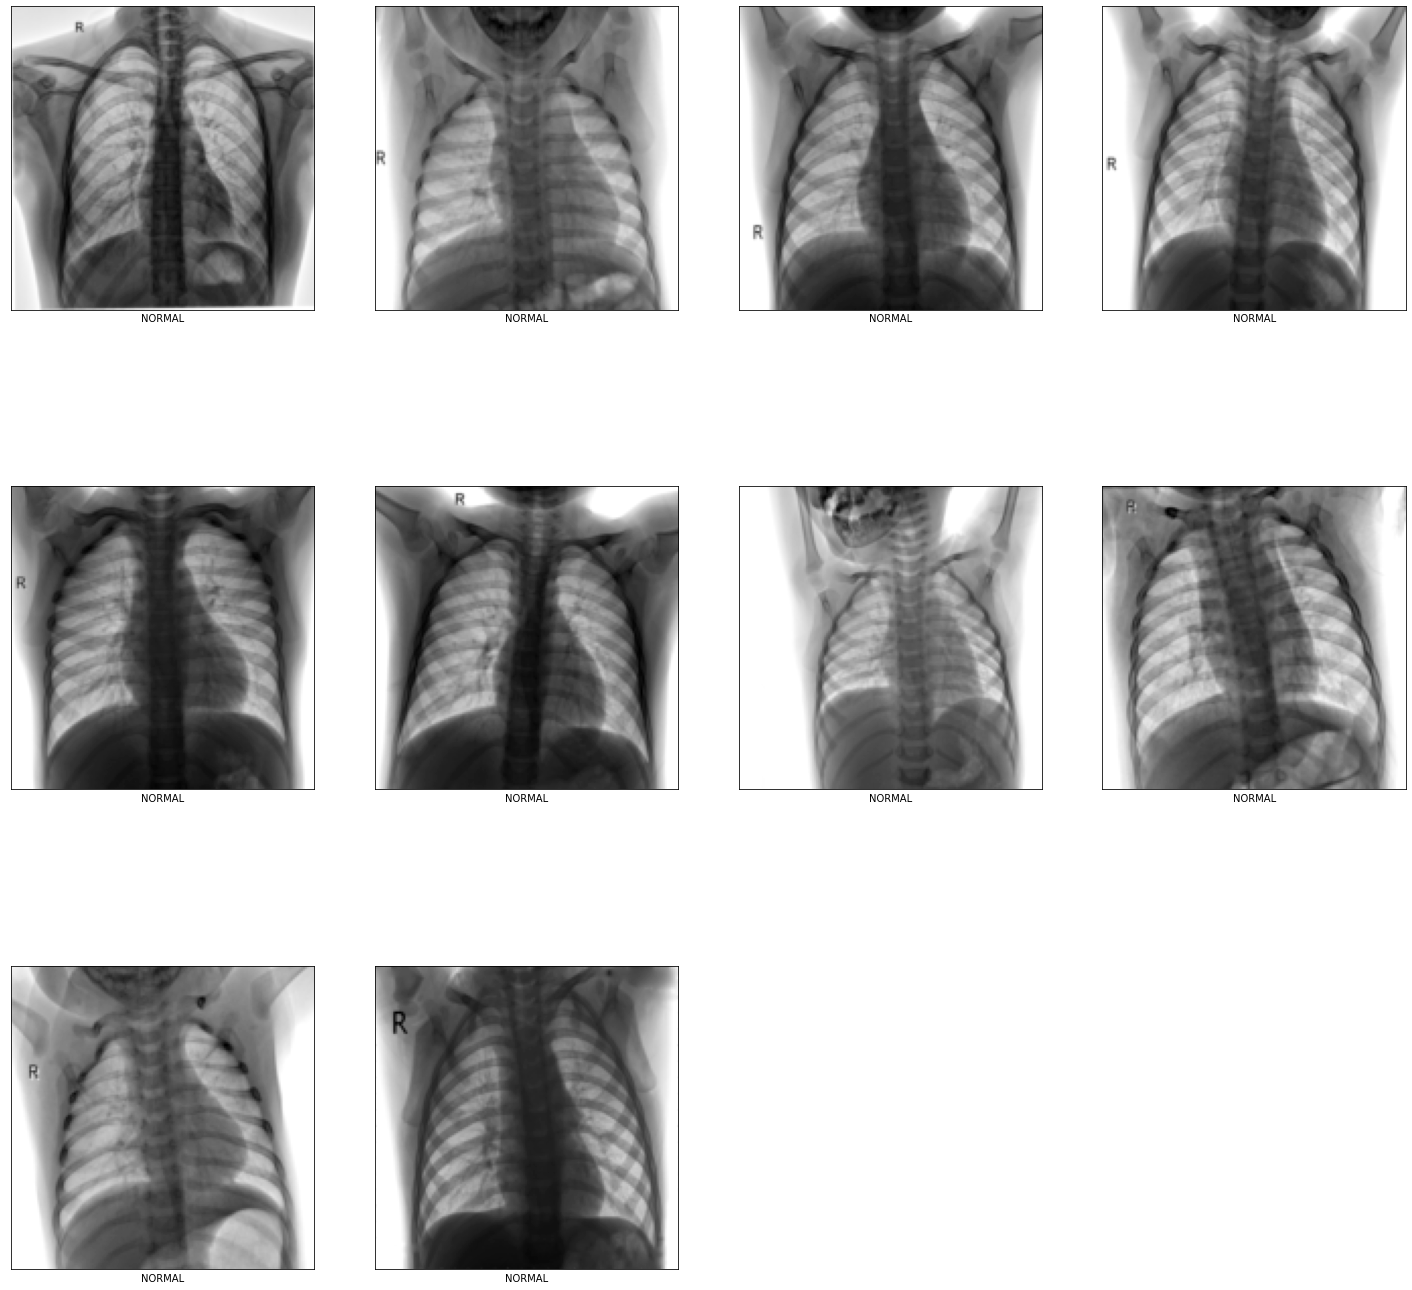

In [40]:
plt.figure(figsize=(25,25))
for i in range(3875,3885):
    j = i-3875
    plt.subplot(3,4,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [18]:
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

In [19]:
class myCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

Undersample the training data set so that the pneumonia cases and normal cases are equal in training set.  

In [41]:
normal_cases = train_images[train_labels == 1]
no_of_normal_cases = train_images[train_labels == 1].shape[0]
pnemonia_cases = train_images[train_labels == 0]
undersampled_pnemonia_cases  = pnemonia_cases[: no_of_normal_cases]
print("Undersampled pneumonia cases size :" + str(undersampled_pnemonia_cases.shape))


Undersampled pneumonia cases size :(1341, 150, 150)


In [42]:
print(np.concatenate((undersampled_pnemonia_cases , normal_cases) , axis = 0).shape)
undersampled_training_images = np.concatenate((undersampled_pnemonia_cases , normal_cases) , axis = 0)

(2682, 150, 150)


In [43]:
test_images = test_dataset['data']
test_images.shape

(624, 150, 150)

In [44]:
us_training_labels_0 = train_labels[train_labels == 0][:no_of_normal_cases]
train_labels_1 = train_labels[train_labels == 1]
undersampled_training_labels = np.concatenate((us_training_labels_0,train_labels_1), axis = 0)
print("Undersampled training labels shape "+ str(undersampled_training_labels.shape))

Undersampled training labels shape (2682,)


#### Test models by varying layers , hidden neurons, learning rate to get the best accuracy. The batch size is default at 32. 

Epoch 1/10
84/84 [==============================] - 2s 17ms/step - loss: 0.5558 - accuracy: 0.7345 - val_loss: 0.4881 - val_accuracy: 0.7500
Epoch 2/10
84/84 [==============================] - 1s 16ms/step - loss: 0.3321 - accuracy: 0.8911 - val_loss: 0.4262 - val_accuracy: 0.7500
Epoch 3/10
84/84 [==============================] - 1s 16ms/step - loss: 0.2803 - accuracy: 0.8931 - val_loss: 0.4233 - val_accuracy: 0.8750
Epoch 4/10
84/84 [==============================] - 2s 18ms/step - loss: 0.2206 - accuracy: 0.9327 - val_loss: 0.4169 - val_accuracy: 0.8750
Epoch 5/10
84/84 [==============================] - 1s 16ms/step - loss: 0.2190 - accuracy: 0.9260 - val_loss: 0.3375 - val_accuracy: 0.8750
Epoch 6/10
84/84 [==============================] - 1s 15ms/step - loss: 0.1919 - accuracy: 0.9361 - val_loss: 0.3189 - val_accuracy: 0.8750
Epoch 7/10
84/84 [==============================] - 1s 15ms/step - loss: 0.1886 - accuracy: 0.9345 - val_loss: 0.2998 - val_accuracy: 0.8750
Epoch 8/10
84

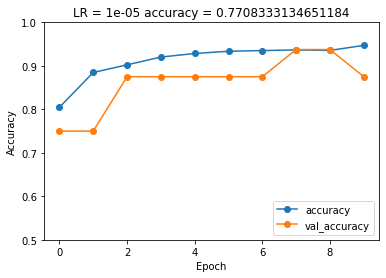

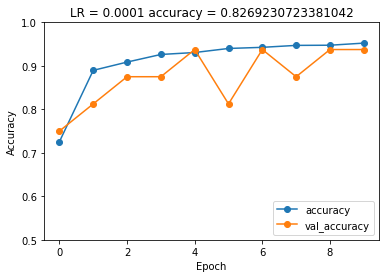

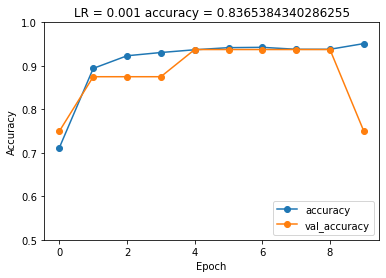

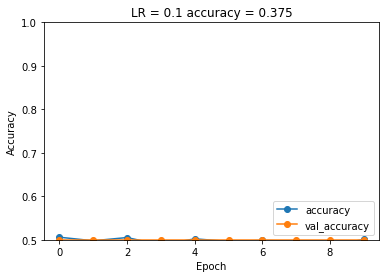

In [134]:
## With single layer , 128 neurons and w/o callback.

training_images= undersampled_training_images
val_images= val_dataset['data']
test_images = test_dataset['data']
##
training_labels = undersampled_training_labels
val_labels = val_dataset['target']
test_labels = test_dataset['target']

for lr in [0.00001, 0.0001, 0.001, 0.1]:
    
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation=tf.nn.relu),
      tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    ])

    optim = tf.keras.optimizers.Adam(
    learning_rate=lr)
    
    model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(training_images, training_labels, epochs=10, validation_data=(val_images, val_labels))
    ##
    test_loss, test_acc = model.evaluate(test_images,test_labels)
    print("Test set image accuracy :{}".format(test_acc))
    ##
    plt.figure()
    plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
    plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title("LR = " + str(lr) + " accuracy = " + str(test_acc))

In [85]:
results = {}
results['model'] = ["With single layer , 128 neurons and w/o callback"]
results['lr'] = [0.0001]
results['acc'] = [0.833]

Learning rate of 0.0001 achieved a high test accuracy of 0.833.  

Epoch 1/10
84/84 [==============================] - 3s 23ms/step - loss: 0.6842 - accuracy: 0.6529 - val_loss: 0.5228 - val_accuracy: 0.7500
Epoch 2/10
84/84 [==============================] - 2s 20ms/step - loss: 0.3663 - accuracy: 0.8817 - val_loss: 0.4611 - val_accuracy: 0.7500
Epoch 3/10
84/84 [==============================] - 1s 15ms/step - loss: 0.3013 - accuracy: 0.8901 - val_loss: 0.4459 - val_accuracy: 0.8750
Epoch 4/10
84/84 [==============================] - 1s 16ms/step - loss: 0.2391 - accuracy: 0.9248 - val_loss: 0.4344 - val_accuracy: 0.8750
Epoch 5/10
84/84 [==============================] - 1s 16ms/step - loss: 0.2316 - accuracy: 0.9202 - val_loss: 0.3688 - val_accuracy: 0.8125
Epoch 6/10
84/84 [==============================] - 1s 16ms/step - loss: 0.2032 - accuracy: 0.9349 - val_loss: 0.3513 - val_accuracy: 0.8125
Epoch 7/10
84/84 [==============================] - 2s 20ms/step - loss: 0.1975 - accuracy: 0.9317 - val_loss: 0.3271 - val_accuracy: 0.8750
Epoch 8/10
84

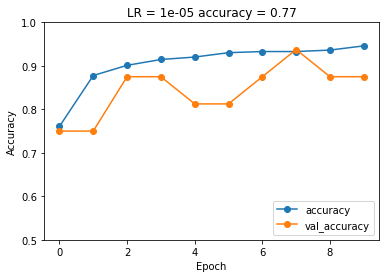

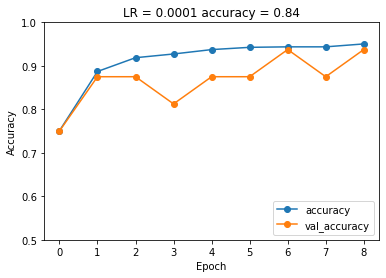

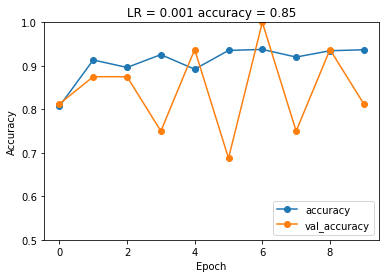

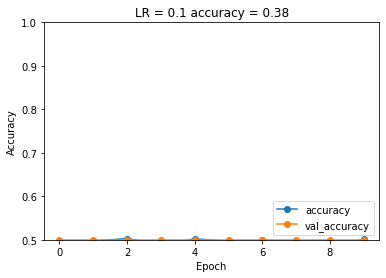

In [81]:
## With single layer , 128 neurons and with callback.

training_images= undersampled_training_images
val_images= val_dataset['data']
test_images = test_dataset['data']
##
training_labels = undersampled_training_labels
val_labels = val_dataset['target']
test_labels = test_dataset['target']

for lr in [0.00001, 0.0001, 0.001, 0.1]:
    
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation=tf.nn.relu),
      tf.keras.layers.Dense(4, activation=tf.nn.softmax)
    ])

    optim = tf.keras.optimizers.Adam(
    learning_rate=lr)
    
    model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(training_images, training_labels, epochs=10, validation_data=(val_images, val_labels), callbacks = [callbacks])
##
    test_loss, test_acc = model.evaluate(test_images,test_labels)
    print("Test set image accuracy :{}".format(test_acc))
##
    plt.figure()
    plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
    plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title("LR = " + str(lr) + " accuracy = " + str(np.round(test_acc, 2)))

In [135]:
## note the results
results['model'].append("With single layer , 128 neurons and with callback")
results['lr'].append(0.001)
results['acc'].append(0.85)

Learning rate of 0.001 achieved test accuracy of 0.85.  

Epoch 1/10
84/84 [==============================] - 2s 17ms/step - loss: 0.5533 - accuracy: 0.7261 - val_loss: 0.5227 - val_accuracy: 0.7500
Epoch 2/10
84/84 [==============================] - 1s 17ms/step - loss: 0.3116 - accuracy: 0.8914 - val_loss: 0.4446 - val_accuracy: 0.8125
Epoch 3/10
84/84 [==============================] - 1s 17ms/step - loss: 0.2600 - accuracy: 0.9052 - val_loss: 0.4560 - val_accuracy: 0.8750
Epoch 4/10
84/84 [==============================] - 2s 20ms/step - loss: 0.2031 - accuracy: 0.9353 - val_loss: 0.4436 - val_accuracy: 0.8750
Epoch 5/10
84/84 [==============================] - 2s 22ms/step - loss: 0.1974 - accuracy: 0.9265 - val_loss: 0.3330 - val_accuracy: 0.8750
Epoch 6/10
84/84 [==============================] - 2s 19ms/step - loss: 0.1718 - accuracy: 0.9391 - val_loss: 0.3068 - val_accuracy: 0.8750
Epoch 7/10
84/84 [==============================] - 1s 14ms/step - loss: 0.1700 - accuracy: 0.9409 - val_loss: 0.2995 - val_accuracy: 0.8750
Epoch 8/10
84

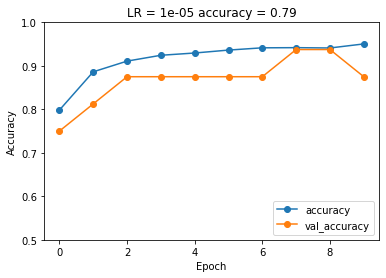

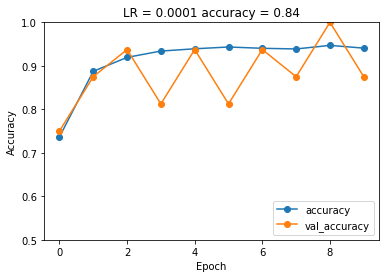

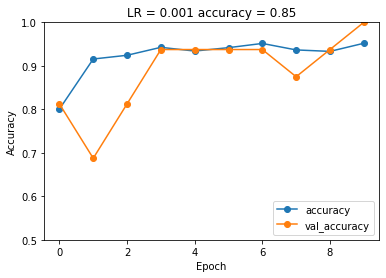

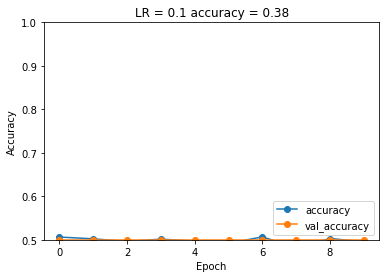

In [136]:
## With two layers , 128 neurons and balanced weights , epochs = 10

training_images= undersampled_training_images
val_images= val_dataset['data']
test_images = test_dataset['data']
##
training_labels = undersampled_training_labels
val_labels = val_dataset['target']
test_labels = test_dataset['target']

for lr in [0.00001, 0.0001, 0.001, 0.1]:

    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    ])

    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(training_images, training_labels, epochs=10, validation_data=(val_images, val_labels) )
    ##
    test_loss, test_acc = model.evaluate(test_images,test_labels)
    print("Test set image accuracy :{}".format(test_acc))
    ##
    plt.figure()
    plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
    plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title("LR = " + str(lr) + " accuracy = " + str(np.round(test_acc, 2)))
    

In [137]:
## note the results
results['model'].append("With two layers , 128 neurons  , epochs = 10")
results['lr'].append(0.001)
results['acc'].append(0.85)

Learning rate of 0.001 results in test accuracy of 0.85.  

Epoch 1/10
84/84 [==============================] - 2s 19ms/step - loss: 0.6288 - accuracy: 0.6949 - val_loss: 0.5176 - val_accuracy: 0.6875
Epoch 2/10
84/84 [==============================] - 2s 20ms/step - loss: 0.3634 - accuracy: 0.8911 - val_loss: 0.4502 - val_accuracy: 0.7500
Epoch 3/10
84/84 [==============================] - 1s 14ms/step - loss: 0.2963 - accuracy: 0.8948 - val_loss: 0.4313 - val_accuracy: 0.8750
Epoch 4/10
84/84 [==============================] - 1s 13ms/step - loss: 0.2305 - accuracy: 0.9330 - val_loss: 0.4282 - val_accuracy: 0.8125
Epoch 5/10
84/84 [==============================] - 1s 13ms/step - loss: 0.2224 - accuracy: 0.9283 - val_loss: 0.3354 - val_accuracy: 0.8125
Epoch 6/10
84/84 [==============================] - 1s 15ms/step - loss: 0.1926 - accuracy: 0.9373 - val_loss: 0.3117 - val_accuracy: 0.8750
Epoch 7/10
84/84 [==============================] - 1s 14ms/step - loss: 0.1866 - accuracy: 0.9335 - val_loss: 0.2878 - val_accuracy: 0.9375
Epoch 8/10
84

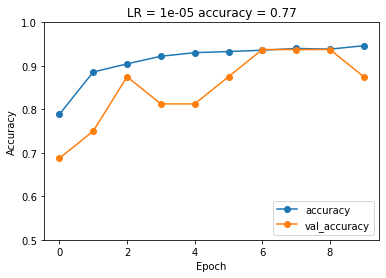

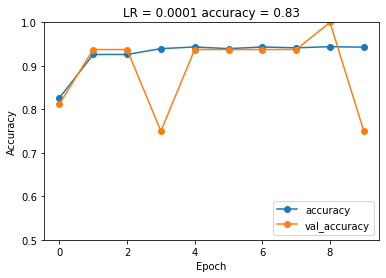

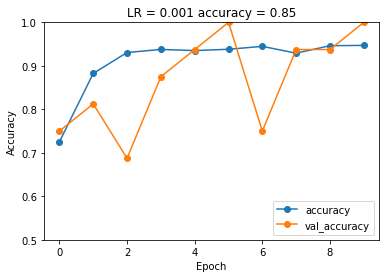

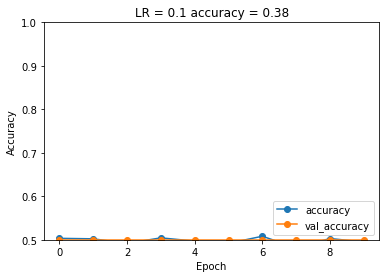

In [138]:
## With three layers , 128 neurons , epochs = 10

training_images= undersampled_training_images
val_images= val_dataset['data']
test_images = test_dataset['data']
##
training_labels = undersampled_training_labels
val_labels = val_dataset['target']
test_labels = test_dataset['target']


for lr in [0.00001, 0.0001, 0.001, 0.1]:

    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    ])

    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(training_images, training_labels, epochs=10, validation_data=(val_images, val_labels) )
    ##
    test_loss, test_acc = model.evaluate(test_images,test_labels)
    print("Test set image accuracy :{}".format(test_acc))
    ##
    plt.figure()
    plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
    plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title("LR = " + str(lr) + " accuracy = " + str(np.round(test_acc, 2)))



In [139]:
## note the results
results['model'].append("With three layers , 128 neurons  , epochs = 10")
results['lr'].append(0.001)
results['acc'].append(0.85)

Learning rate of 0.001 gives a test accuracy of 0.85.  

Epoch 1/10
84/84 [==============================] - 47s 554ms/step - loss: 0.6140 - accuracy: 0.6848 - val_loss: 0.5267 - val_accuracy: 0.7500
Epoch 2/10
84/84 [==============================] - 50s 592ms/step - loss: 0.3789 - accuracy: 0.8867 - val_loss: 0.4629 - val_accuracy: 0.8125
Epoch 3/10
84/84 [==============================] - 52s 617ms/step - loss: 0.3067 - accuracy: 0.8894 - val_loss: 0.4463 - val_accuracy: 0.8750
Epoch 4/10
84/84 [==============================] - 54s 641ms/step - loss: 0.2359 - accuracy: 0.9373 - val_loss: 0.4518 - val_accuracy: 0.8125
Epoch 5/10
84/84 [==============================] - 54s 643ms/step - loss: 0.2209 - accuracy: 0.9310 - val_loss: 0.3473 - val_accuracy: 0.8125
Epoch 6/10
84/84 [==============================] - 53s 634ms/step - loss: 0.1886 - accuracy: 0.9406 - val_loss: 0.3199 - val_accuracy: 0.8750
Epoch 7/10
84/84 [==============================] - 53s 633ms/step - loss: 0.1785 - accuracy: 0.9426 - val_loss: 0.2997 - val_accuracy: 0.9375

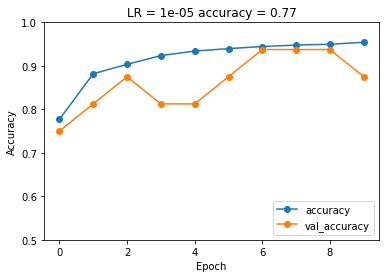

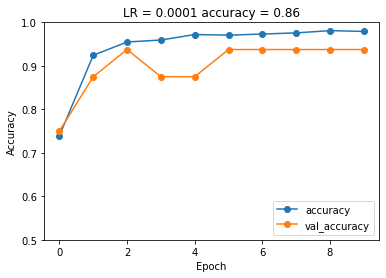

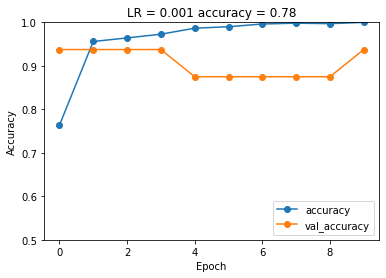

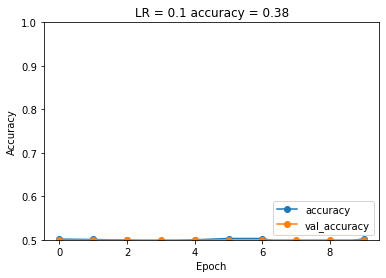

In [140]:
## With Convolution and MaxPooling layers and  128 neurons and balanced weights , epochs = 10

training_images= undersampled_training_images.reshape(-1, 150, 150, 1)
val_images= val_dataset['data'].reshape(-1, 150, 150, 1)
test_images = test_dataset['data'].reshape(-1, 150, 150, 1)

##

training_labels = undersampled_training_labels
val_labels = val_dataset['target']
test_labels = test_dataset['target']



for lr in [0.00001, 0.0001, 0.001, 0.1]:
    
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D( activation='relu', input_shape=(150, 150, 1), filters = 64, kernel_size = 3),
        tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation=tf.nn.relu),
      tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    ])

    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(optimizer= optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(training_images, training_labels, epochs=10, validation_data=(val_images, val_labels))
    ##
    test_loss, test_acc = model.evaluate(test_images,test_labels)
    print("Test set image accuracy :{}".format(test_acc))
    ##
    plt.figure()
    plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
    plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title("LR = " + str(lr) + " accuracy = " + str(np.round(test_acc, 2)))



In [141]:
## note the results
results['model'].append("With Convolution and MaxPooling layers and  128 neurons  , epochs = 10")
results['lr'].append(0.0001)
results['acc'].append(0.86)

Epoch 1/20
84/84 [==============================] - 74s 869ms/step - loss: 0.6564 - accuracy: 0.6447 - val_loss: 0.5209 - val_accuracy: 0.7500
Epoch 2/20
84/84 [==============================] - 85s 1s/step - loss: 0.2972 - accuracy: 0.9056 - val_loss: 0.5387 - val_accuracy: 0.7500
Epoch 3/20
84/84 [==============================] - 84s 999ms/step - loss: 0.1886 - accuracy: 0.9321 - val_loss: 0.3948 - val_accuracy: 0.8750
Epoch 4/20
84/84 [==============================] - 83s 987ms/step - loss: 0.1226 - accuracy: 0.9607 - val_loss: 0.4497 - val_accuracy: 0.8125
Epoch 5/20
84/84 [==============================] - 82s 982ms/step - loss: 0.1193 - accuracy: 0.9553 - val_loss: 0.3249 - val_accuracy: 0.8750
Epoch 6/20
84/84 [==============================] - 82s 977ms/step - loss: 0.0947 - accuracy: 0.9658 - val_loss: 0.2549 - val_accuracy: 0.8125
Epoch 7/20
84/84 [==============================] - 86s 1s/step - loss: 0.1132 - accuracy: 0.9571 - val_loss: 0.2253 - val_accuracy: 0.9375
Epoch

Text(0.5, 1.0, 'LR = 0.1 accuracy = 0.85')

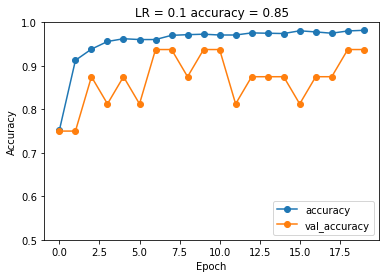

In [142]:
## With 2 layers of Convolution and MaxPooling layers and  128 neurons , epochs = 10 , learnimng rate of 0.0001

training_images= undersampled_training_images.reshape(-1, 150, 150, 1)
val_images= val_dataset['data'].reshape(-1, 150, 150, 1)
test_images = test_dataset['data'].reshape(-1, 150, 150, 1)

##

training_labels = undersampled_training_labels
val_labels = val_dataset['target']
test_labels = test_dataset['target']

    
model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D( activation='relu', input_shape=(150, 150, 1), filters = 64, kernel_size = 3),
tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)),
tf.keras.layers.Conv2D( activation='relu', input_shape=(150, 150, 1), filters = 64, kernel_size = 3),
tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

optim = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
model.compile(optimizer= optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(training_images, training_labels, epochs=20, validation_data=(val_images, val_labels))
    ##
test_loss, test_acc = model.evaluate(test_images,test_labels)
print("Test set image accuracy :{}".format(test_acc))
    ##
plt.figure()
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("LR = " + str(lr) + " accuracy = " + str(np.round(test_acc, 2)))



In [143]:
## note the results
results['model'].append("With 2 layers of Convolution and MaxPooling layers and  128 neurons , epochs = 10 , learnimng rate of 0.0001")
results['lr'].append(0.0001)
results['acc'].append(0.85)

With 3 layers of 128,128 and 512 neurons.  

Epoch 1/10
84/84 [==============================] - 2s 19ms/step - loss: 0.6183 - accuracy: 0.7111 - val_loss: 0.5313 - val_accuracy: 0.7500
Epoch 2/10
84/84 [==============================] - 2s 19ms/step - loss: 0.3876 - accuracy: 0.8865 - val_loss: 0.4616 - val_accuracy: 0.7500
Epoch 3/10
84/84 [==============================] - 2s 22ms/step - loss: 0.3005 - accuracy: 0.8919 - val_loss: 0.4367 - val_accuracy: 0.8125
Epoch 4/10
84/84 [==============================] - 2s 19ms/step - loss: 0.2300 - accuracy: 0.9310 - val_loss: 0.4309 - val_accuracy: 0.8750
Epoch 5/10
84/84 [==============================] - 2s 22ms/step - loss: 0.2191 - accuracy: 0.9251 - val_loss: 0.3492 - val_accuracy: 0.8125
Epoch 6/10
84/84 [==============================] - 2s 21ms/step - loss: 0.1888 - accuracy: 0.9374 - val_loss: 0.3234 - val_accuracy: 0.8125
Epoch 7/10
84/84 [==============================] - 1s 18ms/step - loss: 0.1811 - accuracy: 0.9345 - val_loss: 0.3011 - val_accuracy: 0.8125
Epoch 8/10
84

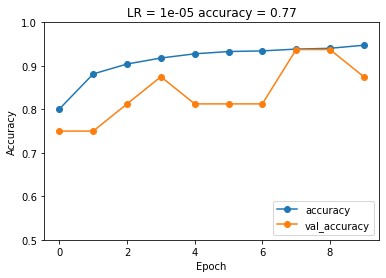

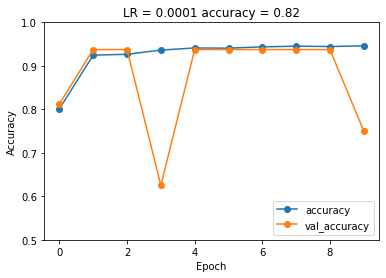

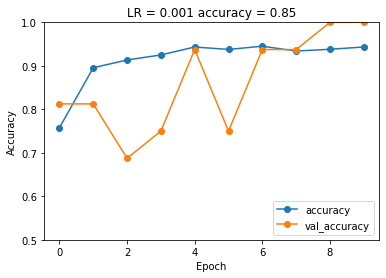

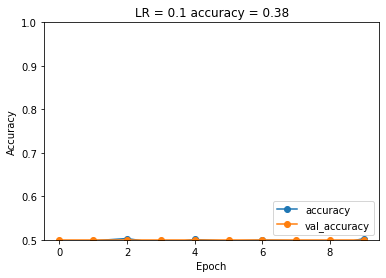

In [144]:
## With three layers , 128 -128-512 neurons and balanced weights , epochs = 10

training_images= undersampled_training_images
val_images= val_dataset['data']
test_images = test_dataset['data']
##
training_labels = undersampled_training_labels
val_labels = val_dataset['target']
test_labels = test_dataset['target']


for lr in [0.00001, 0.0001, 0.001, 0.1]:
    
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
      tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    ])

    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(training_images, training_labels, epochs=10, validation_data=(val_images, val_labels) )
    ##
    test_loss, test_acc = model.evaluate(test_images,test_labels)
    print("Test set image accuracy :{}".format(test_acc))
    ##
    plt.figure()
    plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
    plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title("LR = " + str(lr) + " accuracy = " + str(np.round(test_acc, 2)))
    
    

In [145]:
## note the results
results['model'].append("With three layers , 128 -128-512 neurons , epochs = 10")
results['lr'].append(0.001)
results['acc'].append(0.85)

Learning rate of 0.001 gives test accuracy of 0.85.  

Epoch 1/10
84/84 [==============================] - 2s 20ms/step - loss: 0.6009 - accuracy: 0.7752 - val_loss: 0.5357 - val_accuracy: 0.7500
Epoch 2/10
84/84 [==============================] - 1s 18ms/step - loss: 0.3822 - accuracy: 0.8876 - val_loss: 0.4522 - val_accuracy: 0.8125
Epoch 3/10
84/84 [==============================] - 1s 16ms/step - loss: 0.2952 - accuracy: 0.9018 - val_loss: 0.4449 - val_accuracy: 0.8125
Epoch 4/10
84/84 [==============================] - 1s 13ms/step - loss: 0.2229 - accuracy: 0.9347 - val_loss: 0.4245 - val_accuracy: 0.8750
Epoch 5/10
84/84 [==============================] - 1s 14ms/step - loss: 0.2103 - accuracy: 0.9284 - val_loss: 0.3265 - val_accuracy: 0.8750
Epoch 6/10
84/84 [==============================] - 1s 14ms/step - loss: 0.1810 - accuracy: 0.9436 - val_loss: 0.2970 - val_accuracy: 0.9375
Epoch 7/10
84/84 [==============================] - 1s 14ms/step - loss: 0.1742 - accuracy: 0.9435 - val_loss: 0.2852 - val_accuracy: 0.8750
Epoch 8/10
84

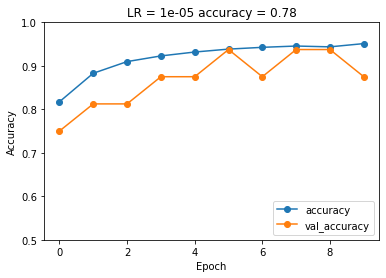

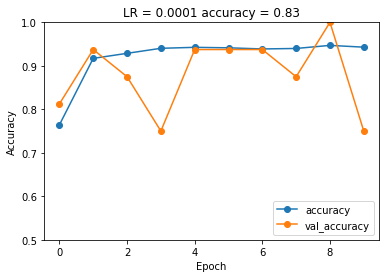

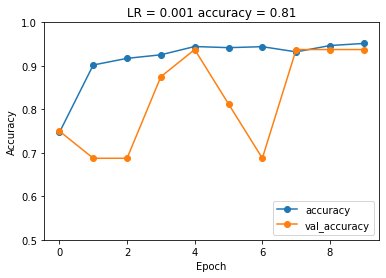

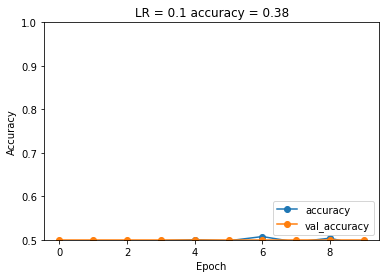

In [146]:
## With 4 layers of 128 neurons and balanced weights , epochs = 10

training_images= undersampled_training_images
val_images= val_dataset['data']
test_images = test_dataset['data']
##
training_labels = undersampled_training_labels
val_labels = val_dataset['target']
test_labels = test_dataset['target']


for lr in [0.00001, 0.0001, 0.001, 0.1]:
    
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
      tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    ])

    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(training_images, training_labels, epochs=10, validation_data=(val_images, val_labels) )
    ##
    test_loss, test_acc = model.evaluate(test_images,test_labels)
    print("Test set image accuracy :{}".format(test_acc))
    ##
    plt.figure()
    plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
    plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title("LR = " + str(lr) + " accuracy = " + str(np.round(test_acc, 2)))


In [147]:
## note the results
results['model'].append("With 4 layers of 128 neurons , epochs = 10")
results['lr'].append(0.0001)
results['acc'].append(0.83)

In [148]:
for key,val in results.items():
    print(key + "-")
    print(val)
    print("\n")

    
    

model-
['With single layer , 128 neurons and w/o callback', 'With single layer , 128 neurons and with callback', 'With two layers , 128 neurons  , epochs = 10', 'With three layers , 128 neurons  , epochs = 10', 'With Convolution and MaxPooling layers and  128 neurons  , epochs = 10', 'With three layers , 128 -128-512 neurons and balanced weights , epochs = 10', 'With 2 layers of Convolution and MaxPooling layers and  128 neurons , epochs = 10 , learnimng rate of 0.0001', 'With three layers , 128 -128-512 neurons , epochs = 10', 'With 4 layers of 128 neurons , epochs = 10', 'With single layer , 128 neurons and with callback', 'With two layers , 128 neurons  , epochs = 10', 'With three layers , 128 neurons  , epochs = 10', 'With Convolution and MaxPooling layers and  128 neurons  , epochs = 10', 'With 2 layers of Convolution and MaxPooling layers and  128 neurons , epochs = 10 , learnimng rate of 0.0001', 'With three layers , 128 -128-512 neurons , epochs = 10', 'With 4 layers of 128 neu

In [151]:
r_acc  = results['acc']
r_model = results['model']
r_lr = results['lr']
print("Best Accuracy {} ".format(np.max(r_acc)))
print("Model with best acc - {}".format(r_model[r_acc.index(np.max(r_acc))]))
print("Model with best lr - {}".format(r_lr[r_acc.index(np.max(r_acc))]))

Best Accuracy 0.86 
Model with best acc - With two layers , 128 neurons  , epochs = 10
Model with best lr - 0.001


Best model so far... 

Epoch 1/10
84/84 [==============================] - 2s 23ms/step - loss: 1.9972 - accuracy: 0.6458 - val_loss: 0.3848 - val_accuracy: 0.8125
Epoch 2/10
84/84 [==============================] - 1s 15ms/step - loss: 0.2207 - accuracy: 0.9124 - val_loss: 0.2924 - val_accuracy: 0.9375
Epoch 3/10
84/84 [==============================] - 1s 15ms/step - loss: 0.2123 - accuracy: 0.9151 - val_loss: 0.6885 - val_accuracy: 0.6875
Epoch 4/10
84/84 [==============================] - 1s 15ms/step - loss: 0.2012 - accuracy: 0.9183 - val_loss: 0.4473 - val_accuracy: 0.8125
Epoch 5/10
84/84 [==============================] - 1s 16ms/step - loss: 0.1487 - accuracy: 0.9411 - val_loss: 0.1712 - val_accuracy: 0.9375
Epoch 6/10
84/84 [==============================] - 1s 18ms/step - loss: 0.1469 - accuracy: 0.9387 - val_loss: 0.1520 - val_accuracy: 0.9375
Epoch 7/10
84/84 [==============================] - 1s 16ms/step - loss: 0.1296 - accuracy: 0.9496 - val_loss: 0.1428 - val_accuracy: 1.0000
Epoch 8/10
84

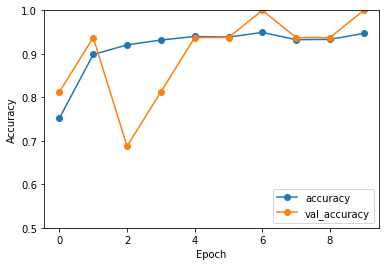

In [152]:
## With two layers , 128 neurons  , epochs = 10

training_images= undersampled_training_images
val_images= val_dataset['data']
test_images = test_dataset['data']
##
training_labels = undersampled_training_labels
val_labels = val_dataset['target']
test_labels = test_dataset['target']



model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

optim = tf.keras.optimizers.Adam(learning_rate= 0.001)
    
model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(training_images, training_labels, epochs=10, validation_data=(val_images, val_labels) )
##
test_loss, test_acc = model.evaluate(test_images,test_labels)
print("Test set image accuracy :{}".format(test_acc))
##

plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

##




In [153]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_images)
## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(predictions)):
    pred_label = np.argmax(predictions[i])
    test_predicted_labels.append(pred_label)
##
print("Classification report :\n{}\n".format(
     metrics.classification_report(test_labels, test_predicted_labels)))

Classification report :
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       390
           1       0.83      0.77      0.80       234

    accuracy                           0.85       624
   macro avg       0.85      0.84      0.84       624
weighted avg       0.85      0.85      0.85       624




In [154]:
print("Confusion matrix :\n{}\n".format(
     metrics.confusion_matrix(test_labels, test_predicted_labels)))

Confusion matrix :
[[352  38]
 [ 54 180]]



Epoch 1/10
84/84 [==============================] - 2s 17ms/step - loss: 1.7513 - accuracy: 0.6746 - val_loss: 0.3717 - val_accuracy: 0.8750
Epoch 2/10
84/84 [==============================] - 1s 16ms/step - loss: 0.2104 - accuracy: 0.9184 - val_loss: 0.3108 - val_accuracy: 0.8750
Epoch 3/10
84/84 [==============================] - 2s 21ms/step - loss: 0.2018 - accuracy: 0.9193 - val_loss: 0.4003 - val_accuracy: 0.8125
Epoch 4/10
84/84 [==============================] - 2s 18ms/step - loss: 0.1892 - accuracy: 0.9260 - val_loss: 0.4374 - val_accuracy: 0.8125
Epoch 5/10
84/84 [==============================] - 1s 16ms/step - loss: 0.1748 - accuracy: 0.9300 - val_loss: 0.2371 - val_accuracy: 0.9375
Epoch 6/10
84/84 [==============================] - 1s 15ms/step - loss: 0.1456 - accuracy: 0.9434 - val_loss: 0.2146 - val_accuracy: 0.9375
Epoch 7/10
84/84 [==============================] - 1s 14ms/step - loss: 0.1447 - accuracy: 0.9408 - val_loss: 0.2171 - val_accuracy: 1.0000
Epoch 8/10
84

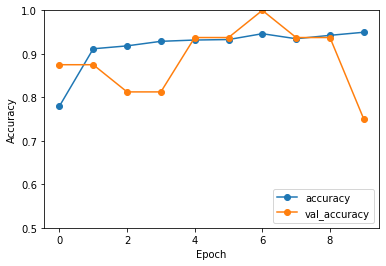

In [155]:
## Adding a  dropout layer to reduce overfitting.

## And With two layers , 128 neurons  , epochs = 10

training_images= undersampled_training_images
val_images= val_dataset['data']
test_images = test_dataset['data']
##
training_labels = undersampled_training_labels
val_labels = val_dataset['target']
test_labels = test_dataset['target']



model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

optim = tf.keras.optimizers.Adam(learning_rate= 0.001)
    
model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(training_images, training_labels, epochs=10, validation_data=(val_images, val_labels) )
##
test_loss, test_acc = model.evaluate(test_images,test_labels)
print("Test set image accuracy :{}".format(test_acc))
##

plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

##

probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_images)
## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(predictions)):
    pred_label = np.argmax(predictions[i])
    test_predicted_labels.append(pred_label)
##
print("Confusion matrix :\n{}\n".format(
     metrics.confusion_matrix(test_labels, test_predicted_labels)))


Accuracy remains the same. However the recall of pneumonia cases has reduced.  

With two dropout layers.

Epoch 1/10
84/84 [==============================] - 2s 19ms/step - loss: 1.8853 - accuracy: 0.5626 - val_loss: 0.5247 - val_accuracy: 0.7500
Epoch 2/10
84/84 [==============================] - 1s 16ms/step - loss: 0.4024 - accuracy: 0.7917 - val_loss: 0.3858 - val_accuracy: 0.8750
Epoch 3/10
84/84 [==============================] - 1s 16ms/step - loss: 0.3370 - accuracy: 0.8287 - val_loss: 0.5429 - val_accuracy: 0.6875
Epoch 4/10
84/84 [==============================] - 1s 17ms/step - loss: 0.3538 - accuracy: 0.8159 - val_loss: 0.6756 - val_accuracy: 0.6875
Epoch 5/10
84/84 [==============================] - 2s 18ms/step - loss: 0.2948 - accuracy: 0.8396 - val_loss: 0.2921 - val_accuracy: 0.9375
Epoch 6/10
84/84 [==============================] - 1s 15ms/step - loss: 0.2709 - accuracy: 0.8472 - val_loss: 0.2622 - val_accuracy: 0.9375
Epoch 7/10
84/84 [==============================] - 1s 14ms/step - loss: 0.2591 - accuracy: 0.8511 - val_loss: 0.2259 - val_accuracy: 0.9375
Epoch 8/10
84

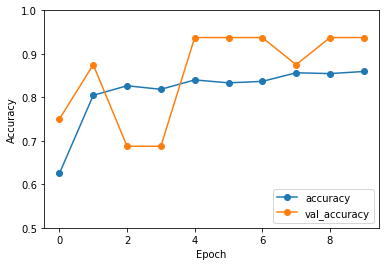

In [156]:
## with 2 dropout layer 

## With two layers , 128 neurons  , epochs = 10

training_images= undersampled_training_images
val_images= val_dataset['data']
test_images = test_dataset['data']
##
training_labels = undersampled_training_labels
val_labels = val_dataset['target']
test_labels = test_dataset['target']



model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

optim = tf.keras.optimizers.Adam(learning_rate= 0.001)
    
model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(training_images, training_labels, epochs=10, validation_data=(val_images, val_labels) )
##
test_loss, test_acc = model.evaluate(test_images,test_labels)
print("Test set image accuracy :{}".format(test_acc))
##

plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

##

probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_images)
## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(predictions)):
    pred_label = np.argmax(predictions[i])
    test_predicted_labels.append(pred_label)
##
print("Confusion matrix :\n{}\n".format(
     metrics.confusion_matrix(test_labels, test_predicted_labels)))

print("Classification report :\n{}\n".format(
     metrics.classification_report(test_labels, test_predicted_labels)))

Two dropout layers reduces the accuracy.  
Hence , include only one dropout layer and change the drop out rate and test the model.

Epoch 1/10
84/84 [==============================] - 2s 17ms/step - loss: 1.8296 - accuracy: 0.6755 - val_loss: 0.7774 - val_accuracy: 0.8125
Epoch 2/10
84/84 [==============================] - 1s 17ms/step - loss: 0.2526 - accuracy: 0.8984 - val_loss: 0.3605 - val_accuracy: 0.8750
Epoch 3/10
84/84 [==============================] - 1s 17ms/step - loss: 0.2320 - accuracy: 0.9001 - val_loss: 0.5932 - val_accuracy: 0.7500
Epoch 4/10
84/84 [==============================] - 1s 16ms/step - loss: 0.1677 - accuracy: 0.9384 - val_loss: 0.8648 - val_accuracy: 0.6875
Epoch 5/10
84/84 [==============================] - 1s 16ms/step - loss: 0.1677 - accuracy: 0.9329 - val_loss: 0.2153 - val_accuracy: 0.8750
Epoch 6/10
84/84 [==============================] - 1s 16ms/step - loss: 0.1512 - accuracy: 0.9383 - val_loss: 0.2213 - val_accuracy: 1.0000
Epoch 7/10
84/84 [==============================] - 1s 15ms/step - loss: 0.1698 - accuracy: 0.9327 - val_loss: 0.2394 - val_accuracy: 0.8750
Epoch 8/10
84

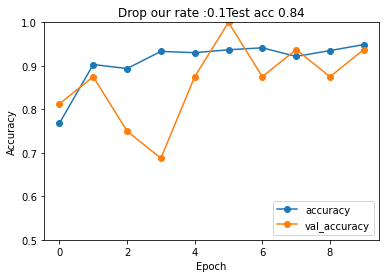

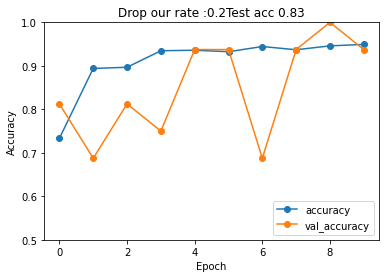

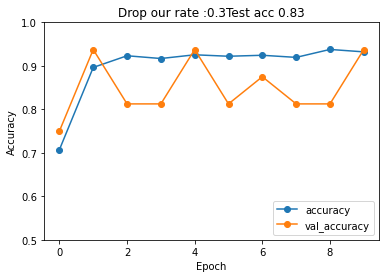

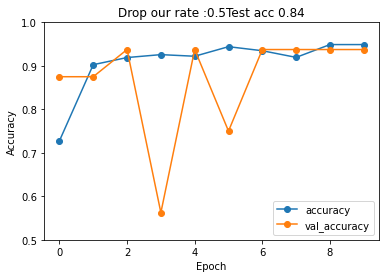

In [157]:
## with 1 dropout layer and changing the dropout rate.

training_images= undersampled_training_images
val_images= val_dataset['data']
test_images = test_dataset['data']
##
training_labels = undersampled_training_labels
val_labels = val_dataset['target']
test_labels = test_dataset['target']


for rate in [0.1, 0.2, 0.3, 0.5]:
    

    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),  
    tf.keras.layers.Dropout(rate),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    ])

    optim = tf.keras.optimizers.Adam(learning_rate= 0.001)
    
    model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(training_images, training_labels, epochs=10, validation_data=(val_images, val_labels))
    ##
    test_loss, test_acc = model.evaluate(test_images,test_labels)
    print("Test set image accuracy :{}".format(test_acc))
##
    plt.figure()
    plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
    plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title("Drop our rate :" +str(rate) + "Test acc " + str(np.round(test_acc,2)))
    ##



Drop rate of 0.1 gives a test accuracy of 0.84.

Epoch 1/10
84/84 [==============================] - 3s 29ms/step - loss: 2.0684 - accuracy: 0.6617 - val_loss: 0.4739 - val_accuracy: 0.8750
Epoch 2/10
84/84 [==============================] - 1s 13ms/step - loss: 0.2151 - accuracy: 0.9129 - val_loss: 0.6788 - val_accuracy: 0.6875
Epoch 3/10
84/84 [==============================] - 1s 13ms/step - loss: 0.2187 - accuracy: 0.9028 - val_loss: 0.6475 - val_accuracy: 0.6875
Epoch 4/10
84/84 [==============================] - 1s 14ms/step - loss: 0.1924 - accuracy: 0.9206 - val_loss: 0.7694 - val_accuracy: 0.6875
Epoch 5/10
84/84 [==============================] - 1s 14ms/step - loss: 0.1698 - accuracy: 0.9312 - val_loss: 0.1780 - val_accuracy: 0.9375
Epoch 6/10
84/84 [==============================] - 1s 15ms/step - loss: 0.1510 - accuracy: 0.9389 - val_loss: 0.2255 - val_accuracy: 0.9375
Epoch 7/10
84/84 [==============================] - 1s 18ms/step - loss: 0.1285 - accuracy: 0.9516 - val_loss: 0.1856 - val_accuracy: 0.9375
Epoch 8/10
84

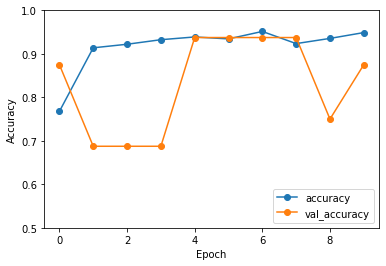

In [158]:
## with 1 dropout layer and drop out rate of 0.1

training_images= undersampled_training_images
val_images= val_dataset['data']
test_images = test_dataset['data']
##
training_labels = undersampled_training_labels
val_labels = val_dataset['target']
test_labels = test_dataset['target']

model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.1),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

optim = tf.keras.optimizers.Adam(learning_rate= 0.001)
    
model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(training_images, training_labels, epochs=10, validation_data=(val_images, val_labels) )
##
test_loss, test_acc = model.evaluate(test_images,test_labels)
print("Test set image accuracy :{}".format(test_acc))
##

plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
##
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_images)
## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(predictions)):
    pred_label = np.argmax(predictions[i])
    test_predicted_labels.append(pred_label)
##
print("Confusion matrix :\n{}\n".format(
     metrics.confusion_matrix(test_labels, test_predicted_labels)))
##
print("Classification report :\n{}\n".format(
     metrics.classification_report(test_labels, test_predicted_labels)))


In [160]:
47/(47+187) , 40/(40 + 350) , 347/(347 +57)

(0.20085470085470086, 0.10256410256410256, 0.8589108910891089)

The model has a poor recall for predicting 'Normal' cases i.e a  - 20% of the normal cases are predicted as 'peumonia' with a recall of 0.8. 
The number of wrongly identified 'pnemonia' cases are less i.e 10% with a recall of 0.9.  
The precision of 'pneumonia' cases is 0.88 which is good as compared to 'normal' cases indicating that we are marking less number of normal cases as pnuemonia.  
How ever the precision of normal cases is less at 0.82 indicating that we are marking higher number of pnuemonia cases as normal.  
  
Total accuracy is at 0.86.  



Try to Better the accuracy with regularization.  

Epoch 1/10
84/84 [==============================] - 3s 32ms/step - loss: 1.9417 - accuracy: 0.6690 - val_loss: 0.6888 - val_accuracy: 0.8750
Epoch 2/10
84/84 [==============================] - 2s 27ms/step - loss: 0.3730 - accuracy: 0.9231 - val_loss: 0.5858 - val_accuracy: 0.8750
Epoch 3/10
84/84 [==============================] - 2s 21ms/step - loss: 0.3454 - accuracy: 0.9157 - val_loss: 0.6578 - val_accuracy: 0.6875
Epoch 4/10
84/84 [==============================] - 2s 24ms/step - loss: 0.2862 - accuracy: 0.9346 - val_loss: 0.3056 - val_accuracy: 0.9375
Epoch 5/10
84/84 [==============================] - 2s 21ms/step - loss: 0.2844 - accuracy: 0.9282 - val_loss: 0.3430 - val_accuracy: 0.8750
Epoch 6/10
84/84 [==============================] - 2s 22ms/step - loss: 0.2506 - accuracy: 0.9330 - val_loss: 0.2363 - val_accuracy: 0.9375
Epoch 7/10
84/84 [==============================] - 2s 21ms/step - loss: 0.2209 - accuracy: 0.9450 - val_loss: 0.2318 - val_accuracy: 0.9375
Epoch 8/10
84

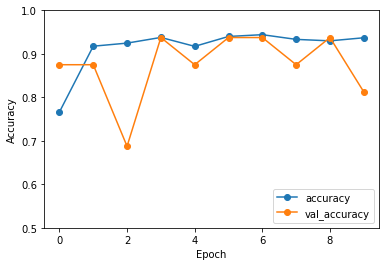

In [161]:
## with 1 dropout layer and l2 regularizations

training_images= undersampled_training_images
val_images= val_dataset['data']
test_images = test_dataset['data']
##
training_labels = undersampled_training_labels
val_labels = val_dataset['target']
test_labels = test_dataset['target']


model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer= tf.keras.regularizers.l2(0.001)),    
tf.keras.layers.Dense(128, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.1),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

optim = tf.keras.optimizers.Adam(learning_rate= 0.001)
    
model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(training_images, training_labels, epochs=10, validation_data=(val_images, val_labels))
##
test_loss, test_acc = model.evaluate(test_images,test_labels)
print("Test set image accuracy :{}".format(test_acc))
##

plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
##
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_images)
## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(predictions)):
    pred_label = np.argmax(predictions[i])
    test_predicted_labels.append(pred_label)
##
print("Confusion matrix :\n{}\n".format(
     metrics.confusion_matrix(test_labels, test_predicted_labels)))
##
print("Classification report :\n{}\n".format(
     metrics.classification_report(test_labels, test_predicted_labels)))


Epoch 1/10
84/84 [==============================] - 3s 32ms/step - loss: 2.1715 - accuracy: 0.6985 - val_loss: 0.5556 - val_accuracy: 0.9375
Epoch 2/10
84/84 [==============================] - 2s 25ms/step - loss: 0.4515 - accuracy: 0.9167 - val_loss: 0.6176 - val_accuracy: 0.8125
Epoch 3/10
84/84 [==============================] - 2s 24ms/step - loss: 0.4303 - accuracy: 0.8951 - val_loss: 0.5676 - val_accuracy: 0.7500
Epoch 4/10
84/84 [==============================] - 2s 25ms/step - loss: 0.3631 - accuracy: 0.9154 - val_loss: 0.4920 - val_accuracy: 0.8750
Epoch 5/10
84/84 [==============================] - 2s 25ms/step - loss: 0.3143 - accuracy: 0.9291 - val_loss: 0.3357 - val_accuracy: 0.9375
Epoch 6/10
84/84 [==============================] - 2s 26ms/step - loss: 0.2707 - accuracy: 0.9409 - val_loss: 0.4416 - val_accuracy: 0.8750
Epoch 7/10
84/84 [==============================] - 2s 30ms/step - loss: 0.2970 - accuracy: 0.9248 - val_loss: 0.3543 - val_accuracy: 0.9375
Epoch 8/10
84

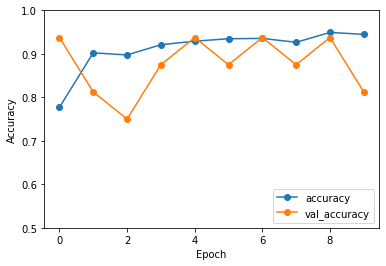

In [162]:
## with 1 dropout layer and l2 regularization in both the  layers

training_images= undersampled_training_images
val_images= val_dataset['data']
test_images = test_dataset['data']
##
training_labels = undersampled_training_labels
val_labels = val_dataset['target']
test_labels = test_dataset['target']


model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer= tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer= tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.1),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

optim = tf.keras.optimizers.Adam(learning_rate= 0.001)
    
model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(training_images, training_labels, epochs=10, validation_data=(val_images, val_labels) )
##
test_loss, test_acc = model.evaluate(test_images,test_labels)
print("Test set image accuracy :{}".format(test_acc))
##

plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
##
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_images)
## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(predictions)):
    pred_label = np.argmax(predictions[i])
    test_predicted_labels.append(pred_label)
##
print("Confusion matrix :\n{}\n".format(
     metrics.confusion_matrix(test_labels, test_predicted_labels)))
##
print("Classification report :\n{}\n".format(
     metrics.classification_report(test_labels, test_predicted_labels)))


No change in the accuracy.But the recall of peumonia cases has reduced .

Pneumonia cases have a higher recall of 0.91 which is an improvement.  
Accuracy is higher at 0.85.  
Precision of Normal cases is 0.83 , indicating that 20% of cases that are marked 'normal'is false. This needs to improve as this stands for wrong diagnosis leading to health implications.  

L2 regularisation does not help in improvimng accuracy or recall.

Trying out L1 regularization.  

Epoch 1/10
84/84 [==============================] - 3s 25ms/step - loss: 14.8504 - accuracy: 0.6360 - val_loss: 4.4257 - val_accuracy: 0.6250
Epoch 2/10
84/84 [==============================] - 2s 29ms/step - loss: 2.9831 - accuracy: 0.8199 - val_loss: 3.4930 - val_accuracy: 0.5000
Epoch 3/10
84/84 [==============================] - 2s 28ms/step - loss: 2.6624 - accuracy: 0.8055 - val_loss: 3.8383 - val_accuracy: 0.6250
Epoch 4/10
84/84 [==============================] - 3s 31ms/step - loss: 2.2533 - accuracy: 0.8493 - val_loss: 1.8831 - val_accuracy: 0.8750
Epoch 5/10
84/84 [==============================] - 3s 32ms/step - loss: 2.0895 - accuracy: 0.8547 - val_loss: 1.9078 - val_accuracy: 0.8125
Epoch 6/10
84/84 [==============================] - 2s 29ms/step - loss: 1.6548 - accuracy: 0.8891 - val_loss: 2.9608 - val_accuracy: 0.5625
Epoch 7/10
84/84 [==============================] - 2s 29ms/step - loss: 1.8053 - accuracy: 0.8778 - val_loss: 1.1107 - val_accuracy: 0.8125
Epoch 8/10
8

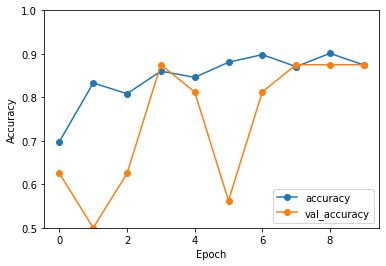

In [163]:
## with 1 dropout layer and l1 regularizations

training_images= undersampled_training_images
val_images= val_dataset['data']
test_images = test_dataset['data']
##
training_labels = undersampled_training_labels
val_labels = val_dataset['target']
test_labels = test_dataset['target']


model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer= tf.keras.regularizers.l1(0.001)),    
tf.keras.layers.Dense(128, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.1),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

optim = tf.keras.optimizers.Adam(learning_rate= 0.001)
    
model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(training_images, training_labels, epochs=10, validation_data=(val_images, val_labels))
##
test_loss, test_acc = model.evaluate(test_images,test_labels)
print("Test set image accuracy :{}".format(test_acc))
##

plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
##
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_images)
## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(predictions)):
    pred_label = np.argmax(predictions[i])
    test_predicted_labels.append(pred_label)
##
print("Confusion matrix :\n{}\n".format(
     metrics.confusion_matrix(test_labels, test_predicted_labels)))
##
print("Classification report :\n{}\n".format(
     metrics.classification_report(test_labels, test_predicted_labels)))


Epoch 1/10
84/84 [==============================] - 3s 25ms/step - loss: 15.6559 - accuracy: 0.6167 - val_loss: 4.3465 - val_accuracy: 0.5000
Epoch 2/10
84/84 [==============================] - 2s 25ms/step - loss: 2.8397 - accuracy: 0.8212 - val_loss: 1.8547 - val_accuracy: 0.8125
Epoch 3/10
84/84 [==============================] - 2s 25ms/step - loss: 1.8117 - accuracy: 0.8542 - val_loss: 1.7471 - val_accuracy: 0.8750
Epoch 4/10
84/84 [==============================] - 3s 30ms/step - loss: 1.4483 - accuracy: 0.9080 - val_loss: 1.4966 - val_accuracy: 0.8750
Epoch 5/10
84/84 [==============================] - 2s 29ms/step - loss: 1.5491 - accuracy: 0.8650 - val_loss: 1.4966 - val_accuracy: 0.7500
Epoch 6/10
84/84 [==============================] - 3s 30ms/step - loss: 1.3436 - accuracy: 0.9038 - val_loss: 2.2081 - val_accuracy: 0.5625
Epoch 7/10
84/84 [==============================] - 3s 31ms/step - loss: 1.7397 - accuracy: 0.8690 - val_loss: 1.3466 - val_accuracy: 0.7500
Epoch 8/10
8

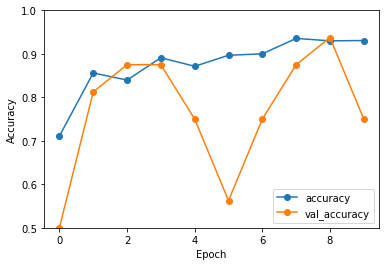

In [164]:
## with 1 dropout layer and l1 regularization in both the  layers

training_images= undersampled_training_images
val_images= val_dataset['data']
test_images = test_dataset['data']
##
training_labels = undersampled_training_labels
val_labels = val_dataset['target']
test_labels = test_dataset['target']


model = tf.keras.models.Sequential([
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer= tf.keras.regularizers.l1(0.001)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer= tf.keras.regularizers.l1(0.001)),
    tf.keras.layers.Dropout(0.1),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

optim = tf.keras.optimizers.Adam(learning_rate= 0.001)
    
model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(training_images, training_labels, epochs=10, validation_data=(val_images, val_labels) )
##
test_loss, test_acc = model.evaluate(test_images,test_labels)
print("Test set image accuracy :{}".format(test_acc))
##

plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
##
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_images)
## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(predictions)):
    pred_label = np.argmax(predictions[i])
    test_predicted_labels.append(pred_label)
##
print("Confusion matrix :\n{}\n".format(
     metrics.confusion_matrix(test_labels, test_predicted_labels)))
##
print("Classification report :\n{}\n".format(
     metrics.classification_report(test_labels, test_predicted_labels)))


L1 regularisation does not help in improving accuracy or recall.    


Summary :  

The best model that gives a good accuracy and precision of pneumonia cases is as shown below.  
Save the model for futher testing it on other chest xray images that can be uploaded on a web app written in Flask. 

Epoch 1/10
84/84 [==============================] - 2s 18ms/step - loss: 1.8325 - accuracy: 0.6050 - val_loss: 0.7382 - val_accuracy: 0.8125
Epoch 2/10
84/84 [==============================] - 1s 17ms/step - loss: 0.2403 - accuracy: 0.8959 - val_loss: 0.2740 - val_accuracy: 0.9375
Epoch 3/10
84/84 [==============================] - 1s 16ms/step - loss: 0.1985 - accuracy: 0.9227 - val_loss: 0.2370 - val_accuracy: 0.8750
Epoch 4/10
84/84 [==============================] - 1s 16ms/step - loss: 0.1576 - accuracy: 0.9333 - val_loss: 0.5808 - val_accuracy: 0.7500
Epoch 5/10
84/84 [==============================] - 1s 16ms/step - loss: 0.1822 - accuracy: 0.9274 - val_loss: 0.2124 - val_accuracy: 0.9375
Epoch 6/10
84/84 [==============================] - 1s 15ms/step - loss: 0.1746 - accuracy: 0.9338 - val_loss: 0.1719 - val_accuracy: 0.9375
Epoch 7/10
84/84 [==============================] - 1s 15ms/step - loss: 0.1652 - accuracy: 0.9291 - val_loss: 0.2143 - val_accuracy: 0.9375
Epoch 8/10
84

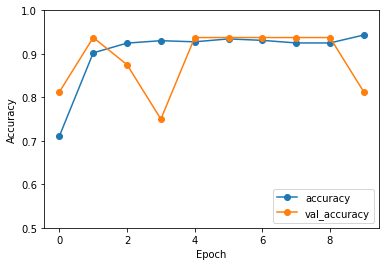

In [55]:
## with 1 dropout layer and drop out rate of 0.1

## here we are reshaping the train data array so that we can remove the flatten layer in the model.
## Need this change done so that we can process jpeg chest x ray image uploaded on the web app and tested using this trained model.

training_images= undersampled_training_images.reshape(-1, 150*150)
val_images= val_dataset['data'].reshape(-1, 150*150)
test_images = test_dataset['data'].reshape(-1, 150*150)
##
training_labels = undersampled_training_labels
val_labels = val_dataset['target']
test_labels = test_dataset['target']

model = tf.keras.models.Sequential([

tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.1),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

optim = tf.keras.optimizers.Adam(learning_rate= 0.001)
    
model.compile(optimizer=optim, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(training_images, training_labels, epochs=10, validation_data=(val_images, val_labels) )
##
test_loss, test_acc = model.evaluate(test_images,test_labels)
print("Test set image accuracy :{}".format(test_acc))
##

plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
##
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_images)
## based on the max value of probability , predict the class.
test_predicted_labels = []
for i in range(len(predictions)):
    pred_label = np.argmax(predictions[i])
    test_predicted_labels.append(pred_label)
##
print("Confusion matrix :\n{}\n".format(
     metrics.confusion_matrix(test_labels, test_predicted_labels)))
##
print("Classification report :\n{}\n".format(
     metrics.classification_report(test_labels, test_predicted_labels)))


In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2880128   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 2,896,898
Trainable params: 2,896,898
Non-trainable params: 0
_________________________________________________________________


In [59]:
model_name = 'chest_xray_classify.h5'
model.save(model_name, save_format='h5')

In [60]:
new_model = tf.keras.models.load_model(model_name)
print(new_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2880128   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 2,896,898
Trainable params: 2,896,898
Non-trainable params: 0
_________________________________________________________________
None


In [68]:
loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

20/20 - 0s - loss: 0.3862 - accuracy: 0.8542
Restored model, accuracy: 85.42%
